# Title LA Restaurants Analysis
### Author: Xia Cui 

### Introduction 

This report presents the analysis of the restaurants in Los Angeles. Findings of the analysis are to inform a proposed robot-run cafe project that hopes to attract potential investors. 

The project is promising but expensive, so the partnership who proposed the projet need to know the current market conditions so as to make sure they will be able to maintain their success when the novelty of robot waiters wears off. 

To this end, the analysis of the LA restaurant data will focus on the following key aspects: 

- The proportion of chain and nonchain establishments, as well as the various type of establishments; 

- What characterize chains, in terms of establishment type, number, and size; 

- How big is each type of establishment on average? 

- What streets have a lot of restaurants, and what only have one?

- What are the seats number like for restaurants on popular street? 

In what follows, we will import and preprocess the data first, then presents the analysis and conclude with findings and recommendations. 


### Table of content 
#### [Part 1: Data importing](#importing)  
#### [Part 2: Data preprocessing](#preprocessing)  
#### [Part 3: Data analysis](#eda)  
#### [Part 4: Findings and conclusions](#conclusion)  

In [1]:
pip install "notebook>=5.3" "ipywidgets>=7.5"

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px 
#import cufflinks as cf
from plotly import graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
init_notebook_mode(connected=True)
#cf.go_offline()
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('colorblind')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /Users/xiac/anaconda3/lib/python3.8/site-packages (4.14.3)


### Part 1: Data importing

<a id="importing"></a>

To optimize data importing, we will check the first 100 rows first. 

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/rest_data_us.csv',
                 nrows=100)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           100 non-null    int64 
 1   object_name  100 non-null    object
 2   address      100 non-null    object
 3   chain        100 non-null    bool  
 4   object_type  100 non-null    object
 5   number       100 non-null    int64 
dtypes: bool(1), int64(2), object(3)
memory usage: 22.8 KB


In [5]:
df['object_type'].value_counts()

Restaurant    74
Fast Food     14
Bakery         7
Bar            2
Cafe           2
Pizza          1
Name: object_type, dtype: int64

Columns look mostly fine, except that *object_type* should be of category type, *chain* should be of boolean type, and int16 should be sufficient for *number* and int32 sufficient for *id*.  Let's change that when importing the whole dataset. 

In [48]:
rest_data = pd.read_csv('https://code.s3.yandex.net/datasets/rest_data_us.csv',
                        dtype={'object_type': 'category', 
                              'id': 'int32',
                              'number': 'int16',
                              'chain': 'boolean'})
rest_data.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


Let's first check the general information of the data.

In [49]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           9651 non-null   int32   
 1   object_name  9651 non-null   object  
 2   address      9651 non-null   object  
 3   chain        9648 non-null   boolean 
 4   object_type  9651 non-null   category
 5   number       9651 non-null   int16   
dtypes: boolean(1), category(1), int16(1), int32(1), object(2)
memory usage: 235.9+ KB


In [8]:
rest_data.shape

(9651, 6)

Let's now check for null values and duplicates. 

In [9]:
rest_data.isna().sum()

id             0
object_name    0
address        0
chain          3
object_type    0
number         0
dtype: int64

There are three null values in *object* type. We will address this before the analysis and plotting. 

In [10]:
rest_data.duplicated().sum()

0

In this project, it is reasonable to have duplicated address and object_names, but if the combination of object_type, object_name, address, and chain are duplicated, there might be some entry errors. Let's check on that.

In [ ]:
rest_data[[]]

In [50]:
rest_data[['object_name', 'address',
           'chain', 'object_type']].duplicated().sum()

0

None as well. So far so good. Later we will check on duplicates again when we change the input to all lower cases. For now, let's check the numeric column *number*. 

In [51]:
rest_data['number'].describe()

count    9651.000000
mean       43.695161
std        47.622874
min         1.000000
25%        14.000000
50%        27.000000
75%        46.000000
max       229.000000
Name: number, dtype: float64

Numeric data looks fine too. 

### Part 1 Summary 

Data checking reveals a few issues we will address next in preprocessing:

- There are three missing values in the *chain* column; 
- *object_name* and *address* are both in upper cases, so is the first letter in *object* type. We will need to change them to all lower cases and check for duplicates again. 
- Given the tasks, we will also separate the street from *address* and put them in a separate column. 

### Part 2: Data preprocessing 

<a id="preprocessing"></a>

In this section, we will deal with the missing values, change the upper cases in data entries, and create a *street_name* column. 

**Addressing missing values**

First, let's see which 3 rows having missing chains. 

In [13]:
rest_data[rest_data['chain'].isna()]

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35


Let's find out if there are restaurants with the same name in the data, in which case we can be sure these will be chain as well. 

In [14]:
na_list = rest_data[rest_data['chain'].isna()]['object_name'].values

In [15]:
rest_data[rest_data['object_name'].isin(na_list)]

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35


In [16]:
rest_data[rest_data['chain'] == True]['object_name'].value_counts().tail(5)

COHEN GLATT RESTAURANT             1
EL DELFIN RESTAURANT               1
LAACO LTD                          1
THE COFFEE BEAN & TEA LEAF #348    1
BIBIGO-REMOTE STORAGE              1
Name: object_name, dtype: int64

They are unique names. This could indicate they are not chain restaurant but a quick look at how many restaurants there are for each chain shows that there are also chainswith only one restaurant. 

There are only 3 rows so let's drop them. 

In [17]:
rest_data = rest_data.dropna()

In [18]:
rest_data.isna().sum()

id             0
object_name    0
address        0
chain          0
object_type    0
number         0
dtype: int64

**Changing upper cases**

Now, let's change the values in the data to all lower case and check for duplicates again. 

In [19]:
rest_data[['object_name', 'address', 'object_type']] = rest_data[[
    'object_name', 'address', 'object_type'
]].apply(lambda x: x.str.lower())

In [20]:
rest_data.head()

,id,object_name,address,chain,object_type,number
0,11786,habitat coffee shop,3708 n eagle rock blvd,False,cafe,26
1,11787,reilly's,100 world way # 120,False,restaurant,9
2,11788,street churros,6801 hollywood blvd # 253,False,fast food,20
3,11789,triniti echo park,1814 w sunset blvd,False,restaurant,22
4,11790,pollen,2100 echo park ave,False,restaurant,20


Now let's check again to see if the restaurant name and address combo have any duplicates. 

In [21]:
rest_data[['object_name', 'address']].duplicated().sum()

0

Still no duplicates. Awesome!

**Adding the street column**

Let's take a look at what the addresses look like. 

In [22]:
rest_data['address'].value_counts()

3607 trousdale pkwy         11
135 n grand ave             10
600 world way                9
5151 state university dr     9
400 world way                9
                            ..
600 w 9th st # c116-         1
1111 s hope st # #100        1
8039 s vermont ave           1
5160 e olympic blvd          1
1249 s grand ave             1
Name: address, Length: 8510, dtype: int64

From what we can see, the numbers at the start of the address is the street number, and thus will need to be removed in the street name. There is also the # symbol in the names. Let's see what these are like. 

In [23]:
lst = []
for i in rest_data['address'].values:
    if i.find('#') != -1:
        lst.append(i)
print("First 5 addresses with #:\n",
      lst[:5], "\nNumber of addresses containing #:", len(lst))

First 5 addresses with #:
 ['100 world way # 120', '6801 hollywood blvd # 253', '100 world way # 126', '2501 w sunset blvd #a', '244 s oxford ave # 5'] 
Number of addresses containing #: 1549


There are 1549 addresses with # in the name. A look at the first 5 indicates that they are some sort of street number or similar. So to extract the street names, we will need to remove those as well. 

To obtain a street column, let's create a function to get the stripped street name, then apply it to each row to get the new column. 

In [24]:
def extract_street(x):
    pos1 = x.find(' ')
    pos2= x.find('#')
    if pos2 != -1: 
        x=x[pos1+1: pos2]
    else: x=x[pos1: ]
    return x

In [25]:
rest_data['street_name'] = rest_data.apply(lambda row: 
                                           extract_street(row[2]),
                                           axis=1)

In [26]:
rest_data['street_name'].value_counts()

 w sunset blvd             297
 w pico blvd               289
 hollywood blvd            168
 wilshire blvd             161
 s vermont ave             148
                          ... 
 century park e ste 150      1
 n main st fl fl 1           1
 naud st                     1
 wilshire blvd ste 301       1
 clearwater st               1
Name: street_name, Length: 2049, dtype: int64

Now we have a *street_name* column and can see from above that there are streets with over two hundreds restaurants! We will take a closer look at the number of restaurants on streets in a later section. 

### Part 2 summary 

In this section, we addressed the issues of missing values and uppercase inputs. We also added a street column. Now the data is ready for the analysis and plotting. 

### Part 4: Data analysis 

<a id="eda"></a>

In this section, we will analyze the restaurant data and use numbers of plots to address the following key questions: 

- The proportion of chain and nonchain establishments, as well as the various type of establishments; 

- What characterize chains, in terms of establishment type, number, and size; 

- How big is each type of establishment on average in terms of seat numbers? 

- What streets have a lot of restaurants, and what only have one?

- What are the seats number like for restaurants on popular streets? 


First let's take another look at what our data looks like now. 

In [27]:
rest_data.head()

,id,object_name,address,chain,object_type,number,street_name
0,11786,habitat coffee shop,3708 n eagle rock blvd,False,cafe,26,n eagle rock blvd
1,11787,reilly's,100 world way # 120,False,restaurant,9,world way
2,11788,street churros,6801 hollywood blvd # 253,False,fast food,20,hollywood blvd
3,11789,triniti echo park,1814 w sunset blvd,False,restaurant,22,w sunset blvd
4,11790,pollen,2100 echo park ave,False,restaurant,20,echo park ave


First, let's take a look at the proportions of various types of establishements. 

#### 4.1 Proportions of the various types of establishments

In [28]:
rest_data['object_type'].value_counts().values

array([7253, 1066,  435,  319,  292,  283])

In [29]:
fig = go.Figure(go.Pie(labels=rest_data['object_type'].value_counts().index, 
                       values=rest_data['object_type'].value_counts().values))
fig.update_layout(
    title_text='Proportions of types of establishments',
    title_x=0.5)
fig.show() 

75.2% of all establishments are restaurants, followed by fast food (11%), and then cafés(4.51%). The type that represents the smallest portion is bakery(2.93%). 

#### 4.2 Proportions of chain and nonchain establishments

In [30]:
fig = go.Figure(go.Pie(labels=['nonchain', 'chain'],
                       values=rest_data['chain'].value_counts().values))
fig.update_layout(
    title_text='Proportions of chain and nonchain establishments',
    title_x=0.5)
fig.show()

There are a lot more chain nonchain restaurants (61.9%) than chain restaurants (38.1%). This is interesting to know. We will discuss the possiblity of developing the chain for the robot café later in the report. 

#### 4.3 Chain or nonchain by establishment type

Let's also find out which type of establishment is typically a chain. 

In [31]:
object_data = rest_data.groupby(['object_type', 'chain']).agg({
    'number': 'count'}).reset_index()
object_data

fig = px.bar(object_data, x='object_type', y='number', color='chain',
             title='Count of restaurants by establishment',
             labels={'object_type': 'Establishment',
                     'count': 'Count of restaurants'})
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title_x=0.5)
fig.show()

From the above, we can see that bakery is mostly a chain. 

For restaurants, over 2/3 of the establishments are chains. It's about half half for pizza eateries. No surprisingly, there are more chain fast food establishments than nonchains (605 v.s 461). More cafés are nonchain than chain (266 v.s. 169). Most of the bars are, of course, nonchains(215 against 77), as we would expect. 

#### 4.4 Distribution of chain establishment and number of seats 

We are also interested in finding out what characterizes chains. Do chains have a large number of establishments or not? What's the size like in terms of seats? 

To find out, let's plot the distribution of the number of establishments for each chain, and the median number of seats for it. 

First, let's do a quick check on restaurant names to see if it's viable to group by those to identify the number of restaurants in chains. 

In [32]:
rest_data[rest_data['chain'] == True]['object_name'].value_counts()

the coffee bean & tea leaf     47
subway                         31
domino's pizza                 15
kentucky fried chicken         14
waba grill                     14
                               ..
power plant super food cafe     1
taco tu madre restaurant        1
la bellita bakery y pizza       1
domino's pizza #8341            1
starbucks #19883                1
Name: object_name, Length: 2733, dtype: int64

Last one above is a little suspecious. It could be chain is 'chinatown express' and this is the 42th store. In that case, it should be counted as one of the chinatown express shops. Possibly there are other cases like this we will need to pay close attention too. First let's check how many have the name 'chinatown express'. 

In [33]:
rest_data[rest_data['object_name'] == 'chinatown express']

,id,object_name,address,chain,object_type,number,street_name
3474,15260,chinatown express,321 s mcdonell ave,True,fast food,14,s mcdonell ave
5941,17727,chinatown express,1411 echo park ave #101,True,fast food,7,echo park ave
5946,17732,chinatown express,1320 n vine st,True,fast food,32,n vine st
7837,19623,chinatown express,321 s mcdonnell ave,True,fast food,24,s mcdonnell ave
7870,19656,chinatown express,2137 w 6th st,True,fast food,3,w 6th st
7938,19724,chinatown express,304 w florence ave,True,fast food,7,w florence ave


Indeed, there are quite a few. Next, let's find out how many restaurant names contain #. 

In [34]:
name_lst = []
for i in rest_data['object_name'].values:
    if i.find('#') != -1:
        name_lst.append(i)
print("First 5 names with #:\n",
      name_lst[:5], "\nNumber of names containing #:", len(name_lst))

First 5 names with #:
 ['panda express #2596', 'afc sushi at walgreens #1527', 'ralphs market #206', "mrs field's cooki #426", "mcdonald's #2084"] 
Number of names containing #: 994


There are 994 establishment names with #. Luckily we caught this. We can do something similar as in a previous task to extract the chain name from the object_name. 

In [35]:
def extract_chain(x):
    pos= x.find('#')
    if pos != -1: 
        x=x[: pos]
    else: x=x
    return x

In [36]:
chain_data = rest_data[rest_data['chain'] == True]
chain_data['chain_name'] = chain_data.apply(
    lambda row: extract_chain(row[1]),axis=1)
chain_data['chain_name'].value_counts()

starbucks coffee              85
subway                        82
mcdonald's                    67
jack in the box               53
the coffee bean & tea leaf    47
                              ..
phoenix inn restaurant         1
mijacalito restaurant          1
gaam restaurant                1
esperanza's bakery             1
                               1
Name: chain_name, Length: 2161, dtype: int64

Now, let's group the chain_data by chains and make a dataframe containing the number of restaurants in each chain, as well as the median number of seats for each chain. 

In [37]:
chain_data_ = chain_data.groupby(
    'chain_name').agg({'id': 'count', 'number' : 'median'}).reset_index()
chain_data_.columns = ['chain_name', 'number_rest', 'number_seats']

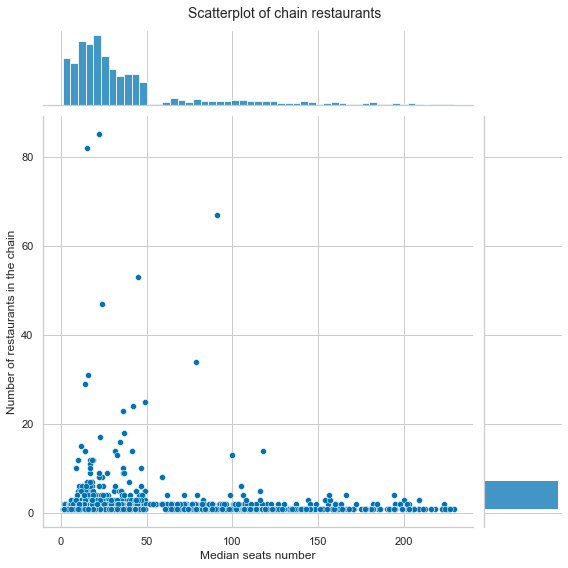

In [38]:
fig = sns.jointplot(x='number_seats',
                    y='number_rest',
                    data=chain_data_,
                   height=8)
plt.suptitle('Scatterplot of chain restaurants', size=14)
fig.set_axis_labels('Median seats number',
                    'Number of restaurants in the chain')
plt.tight_layout()

In [39]:
chain_data_.describe().T

,count,mean,std,min,25%,50%,75%,max
number_rest,2161.0,1.701064,3.785993,1.0,1.0,1.0,1.0,85.0
number_seats,2161.0,39.674688,43.806375,1.0,14.0,24.0,43.0,229.0


From the above, we can see that 75% of chains only have **one** restaurant in LA. This is interesting. How is it a chain if only having one establishment? Maybe these are national or even international chains that only have one premise in LA. We wouldn't know.  

Slightly over two dozen chains have 10 to 20 establishments,6 chains have around 30, and 5 chains have over 40, with the biggest chain having as many as 85 establishments. Among the top chains, the top 3, as we can see from the value_counts results, are starbucks coffee(85 establishments), subway(82), and mcdonald's(67).    

As far as number of seats is concerned, we can see that majority of the chains have their median seats number under 50. The biggest median value for the number of seats in chain establishment is 229. 

It's interesting to see that the chains from the data do not have many restaurants, and the restaurant seats number are mostly under 50. 

While we are here, why not also find out the distribution of the number of seats of overall? Let's do that. 

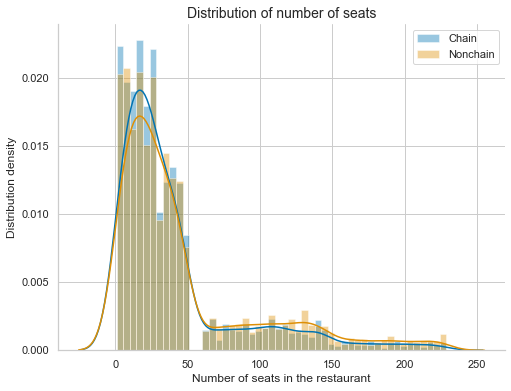

In [40]:
plt.figure(figsize=(8, 6))
sns.distplot(rest_data[rest_data['chain'] == True]['number'], 
             label = 'Chain')
sns.distplot(rest_data[rest_data['chain'] == False]['number'], 
             label = 'Nonchain')
plt.title('Distribution of number of seats',
          size=14)
plt.xlabel('Number of seats in the restaurant')
plt.ylabel('Distribution density')
sns.despine()
plt.legend()
plt.show()

As we can see above, overall, both chain and non chain establishments have a similar distribution of the number of seats, with majority of those under 50. 

#### 4.5 Average number of seats for each type of restaurant

Let's plot a bar plot to show the average number of seats for each type of establishment. 

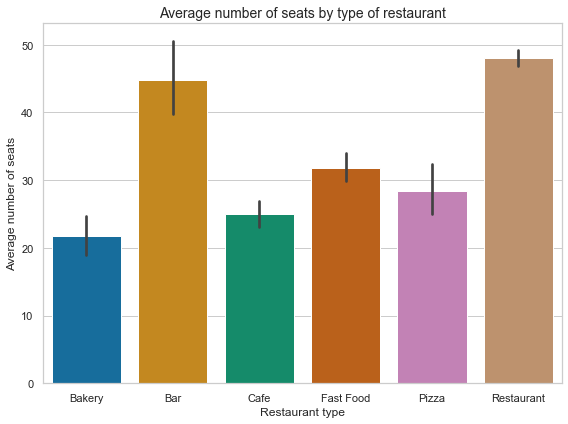

In [52]:
plt.figure(figsize=(8, 6))
fig = sns.barplot(x='object_type', 
                  y='number', 
                  data=rest_data)
plt.title('Average number of seats by type of restaurant', 
             size=14)
plt.xlabel('Restaurant type')
plt.ylabel('Average number of seats')

plt.tight_layout()

From the above, we can see that restaurants have the higher average number of seats (close to 50), followed by bars (approximately 45). 

On average, cafés have 25 seats, fast food have just above 30, pizza have close to 30, and bakey just above 20. 

This is useful information when the project needs to decide what is a viable size for the robot café. 

#### 4.6 Busy and quiet streets for dining

Let's find out what the ten most busy streets for dining are! 

In [42]:
street_ten = rest_data['street_name'].value_counts().head(10)
fig=px.bar(x=street_ten.index, y=street_ten.values,
           title = 'Top 10 streets by number of restaurants',
          labels = ({'x':'Streets', 'y':'Number of restaurants'}))
fig.update_xaxes(tickangle=45)
fig.update_layout(title_x=0.5)

The top two streets from the graph above have over 200 restaurants! Would they be a good place for the new robot café, or there might be too much competition or the rent too expensive. These are all questions to think about. 

For now, let's also find the number of streets that are quiet, ones that only have one restaurant.

In [43]:
rest_street = rest_data.groupby('street_name').agg(
    {'id': 'count'}).reset_index()
rest_street.columns = ['street_name', 'object_number']

print("Number of streets with only one restaurants:", 
      rest_street[rest_street['object_number'] == 1]['street_name'].count())

print("Proportion of streets with only one restaurants:", 
      rest_street[rest_street['object_number'] ==
            1]['street_name'].count()/len(rest_street))

Number of streets with only one restaurants: 1382
Proportion of streets with only one restaurants: 0.6744753538311371


Over two thirds of the streets in the data have only one establishment in their street. 

While some streets are extremely or moderately busy with retaurants, some are very quiet. They could be totally different streets, the former being busy shopping or entertainment strips, whereas latter being small or residential street. The founder of the robot café will need to decide what kind of clients they are looking for when deciding on the location. 

#### 4.7 Distribution of restaurants' number of seats for busy streets

Now let's find out what are the number of seats like for restaurants on popular dining streets. 

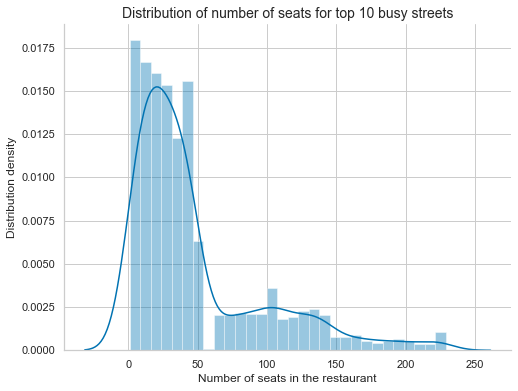

In [44]:
plt.figure(figsize=(8, 6))
fig = sns.distplot(rest_data[rest_data[
    'street_name'].isin(street_ten.index)]['number'],
    bins=30)
plt.title('Distribution of number of seats for top 10 busy streets',
          size=14)
plt.xlabel('Number of seats in the restaurant')
plt.ylabel('Distribution density')
sns.despine()
plt.show()

In [45]:
rest_data[rest_data[
    'street_name'].isin(street_ten.index)]['number'].describe()

count    1751.000000
mean       47.567105
std        48.002999
min         1.000000
25%        16.000000
50%        31.000000
75%        49.000000
max       229.000000
Name: number, dtype: float64

From the graph and stats above, we can see that, majority, actually 75%, of the restaurants on these streets have under 50 seats, despite the extreme higher number as 229. Just out of curiosity, let's find out which restaurant is this one. 

In [46]:
rest_data[rest_data['number'] == 229]

,id,object_name,address,chain,object_type,number,street_name
475,12261,mountaingate country club,12445 mountain gate dr,True,restaurant,229,mountain gate dr
594,12380,kabuki japanese restaurant,1545 n vine st,True,restaurant,229,n vine st
3277,15063,american jewish university,15600 mulhooland dr,False,restaurant,229,mulhooland dr
3495,15281,usc university club,705 w 34th st,False,restaurant,229,w 34th st
4626,16412,playhouse,6506 hollywood blvd,False,restaurant,229,hollywood blvd
4854,16640,wokcano downtown l.a.,800 w 7th st,False,restaurant,229,w 7th st
5091,16877,boulevard 3,6523 w sunset blvd,False,restaurant,229,w sunset blvd
7383,19169,manna korean bbq,3986 wilshire blvd,True,restaurant,229,wilshire blvd
8699,20485,vibiana,210 s main st,False,restaurant,229,s main st


Actually, there are 9 restaurants which have 229 seats, a mix of chain and nonchain, and of different cuisine types. Some are clubs or univeristy premises so no wonder they have so many seats. 

However, why all 229?! This is an intereting coincidence. Is it a magic number, or the maximum entry value? In real life, we probably should check with people who provide the data or google the restaurants just to make sure the data is entered correctly. We will not go there in this report. 

Also, from analysis above, we know there are 1382 streets that only have 1 establishment. What is the distribution of the number of seats like for these restaurants. Let's find out. 

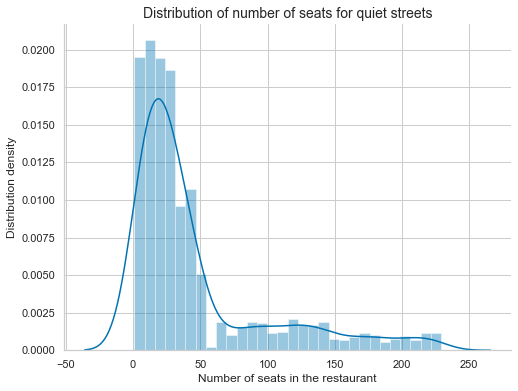

In [47]:
quiet_street = rest_street[rest_street['object_number'] == 1]['street_name']
plt.figure(figsize=(8, 6))
fig = sns.distplot(rest_data[rest_data['street_name'].isin(
    quiet_street.values)]['number'], bins=30)
plt.title('Distribution of number of seats for quiet streets',
          size=14)
plt.xlabel('Number of seats in the restaurant')
plt.ylabel('Distribution density')
sns.despine()
plt.show()

Here above, we see a very similar pattern to the restaurants on busy street. Majority establishments have under 50 seats. This is also useful information for the robot café. 

### Part 3 summary 

In this section, we obtained some valuable information about the characteristics of restaurants, both chain and nonchain, on busy and quiet streets. We will discuss how such information will inform on the proposal of the robot café. 

### Part 4: Findings and conclusions 

<a id="conclusion"></a>

This report so far presents the results of analysis of LA restaurants data. Ideally, if we are to use such results to inform the start of a new establishment, I would also request the data of some sort of indicators of popularity of the restaurants, such as rating and number of google reviews. In our case, we will just need to assume that restaurants in the data are popular and what these are like could be used as a guide for the proposed robot café. 

First, what **type of restaurant** should be proposed to adopt the robot concept? 75% of the establishments are restaurants, followed by fast food, but does this mean these are popular, or there might be a market saturation for those two types. Cafés and bars only represent a small market share given the data (4.51% an 3.03%). This could suggest there are more room for new establishments. Moreover, who would be the targeted population? Would students and young professionals be more likely to embrace the concept? If they were what the owners had in mind, cafés or bars are likely to be a good choice. 

In terms of **location**, if it is cafés or bars that will adopt the robot concept, it will be a good idea to open in locations on popular dining streets, where there will be a lot of foot traffic of the targeted population groups. 

Given the the average number of seats for bars and cafés are 45 and 25 respectively, these might be a good number to start with, depending on what the final choice is. Morever, it's probably a bit risky to have bigger size establishment which will need a lot of robots under one roof without testing the idea first, just in case of technical failure and suddenly the owners will have whole room of metals. 

From the data we also see that there are a lot more non chain than chain establishment in LA. This data alone is not enough. It could suggest people's preference, but we are not sure. The best way would be to conduct a survey among the targeted population and find out what they like. If we have to make a suggestion, it would be safer to go with nonchain. 

On the one hand, it's expensive to set up and therefore hard to predict the demand of such chains. On the other hand, the targeted population might be attracted by its uniqueness, rather than availability. Of course, if down the track it does prove to be consistently popular and there is apparently more market demand for it, the possiblity of developing a chain(imagine robots serving subways) can always be picked up again. 

Last but not least, to make a dining establishment consistently popular even after the novelty of robots wears off, food and service are always of essential importance. Food has to be great, and the service, provided by robot or not, has to be top notch. These will also be noted in the proposal to investors. 





Presentation: <https://drive.google.com/file/d/1Q80x_Sn40O8Y4M348Ybv4eBHiR2VSdAs/view?usp=sharing> 